# Geometric Transformations

In [6]:
import numpy as np # for building and manipulating matrices
import cv2 # for matrix transformations
from ipywidgets import interact
from IPython.display import display, Math, Markdown

# for graphics:
from matplotlib import pyplot as plt
plt.rc('axes', axisbelow=True)

#%matplotlib inline
# nice retina graphics on high-resolution screens
#%config InlineBackend.figure_format='retina'

%matplotlib notebook

## Affine Transformation

<IPython.core.display.Javascript object>


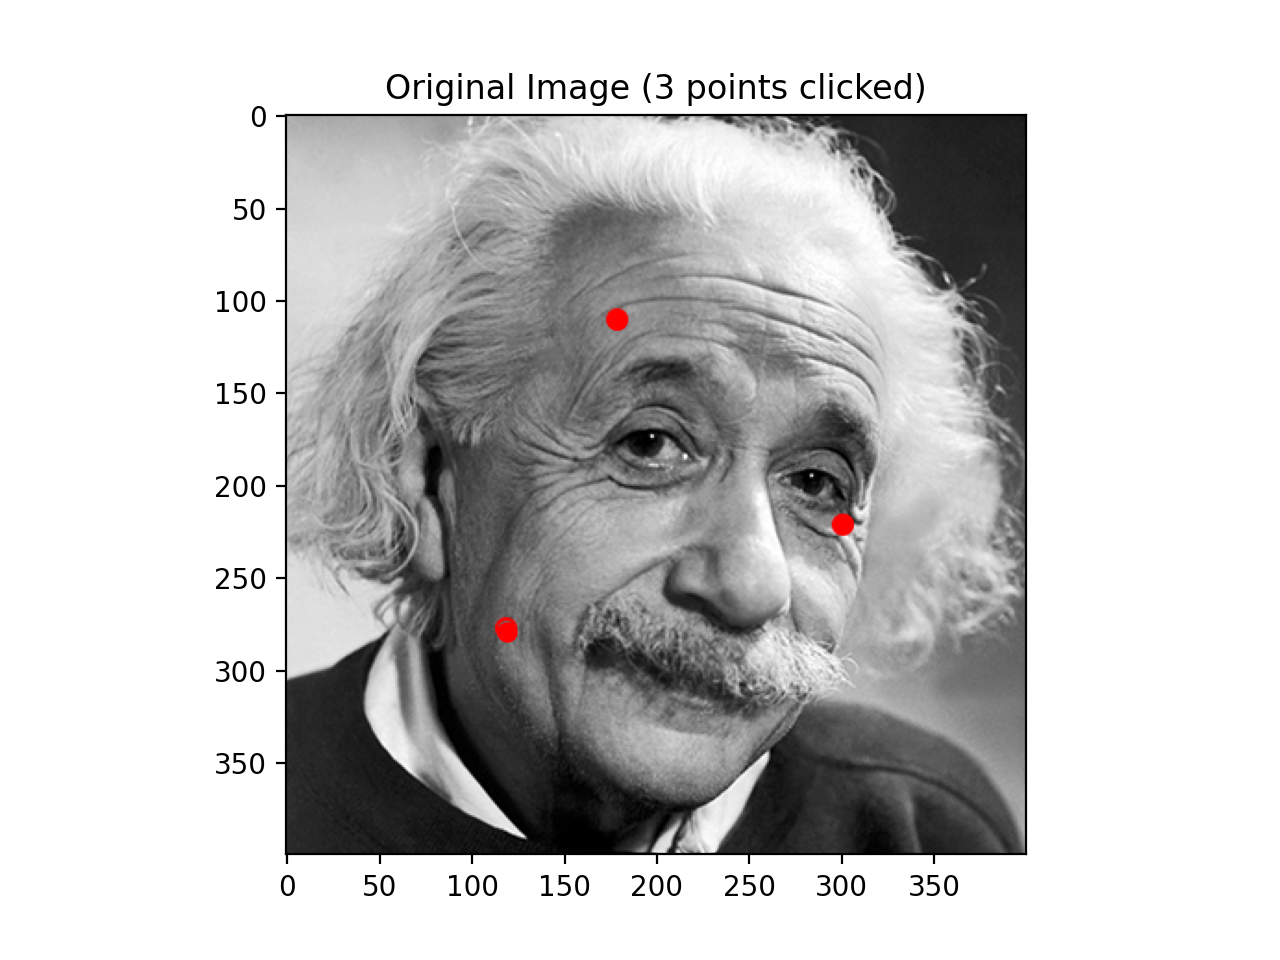

In [15]:
# load image
im = plt.imread( 'images/einstein.png' )

# matrix for storing coordinates
pointsBefore = np.zeros((2,0))

# function handling button clicks
def onclick(event):
    global pointsBefore
    pointsBefore = np.hstack((pointsBefore, [[event.xdata], [event.ydata]]))
    plt.title(f"Original Image ({pointsBefore.shape[1]} points clicked)")
    plt.scatter([event.xdata], [event.ydata], c='r', s=40)

# display original image and prompt user to select 3 points
fig = plt.figure()
plt.imshow(im)
cid = fig.canvas.mpl_connect('button_press_event', onclick) # for handling button click
plt.title("Original Image (Click on the three points)")
plt.show()

In [16]:
print(pointsBefore)

[[118.93993506 300.75811688 178.46374459]
 [279.22977543 220.78821699 110.3986066 ]]


#### Warping

The code snippet below randomly generates an affine transformation and warps the image using this transformation.

In the new warped image, click the three targets in the same order you clicked the three targets in the original. These warped points will be stored as columns in a new `pointsAfter` matrix.

<IPython.core.display.Javascript object>


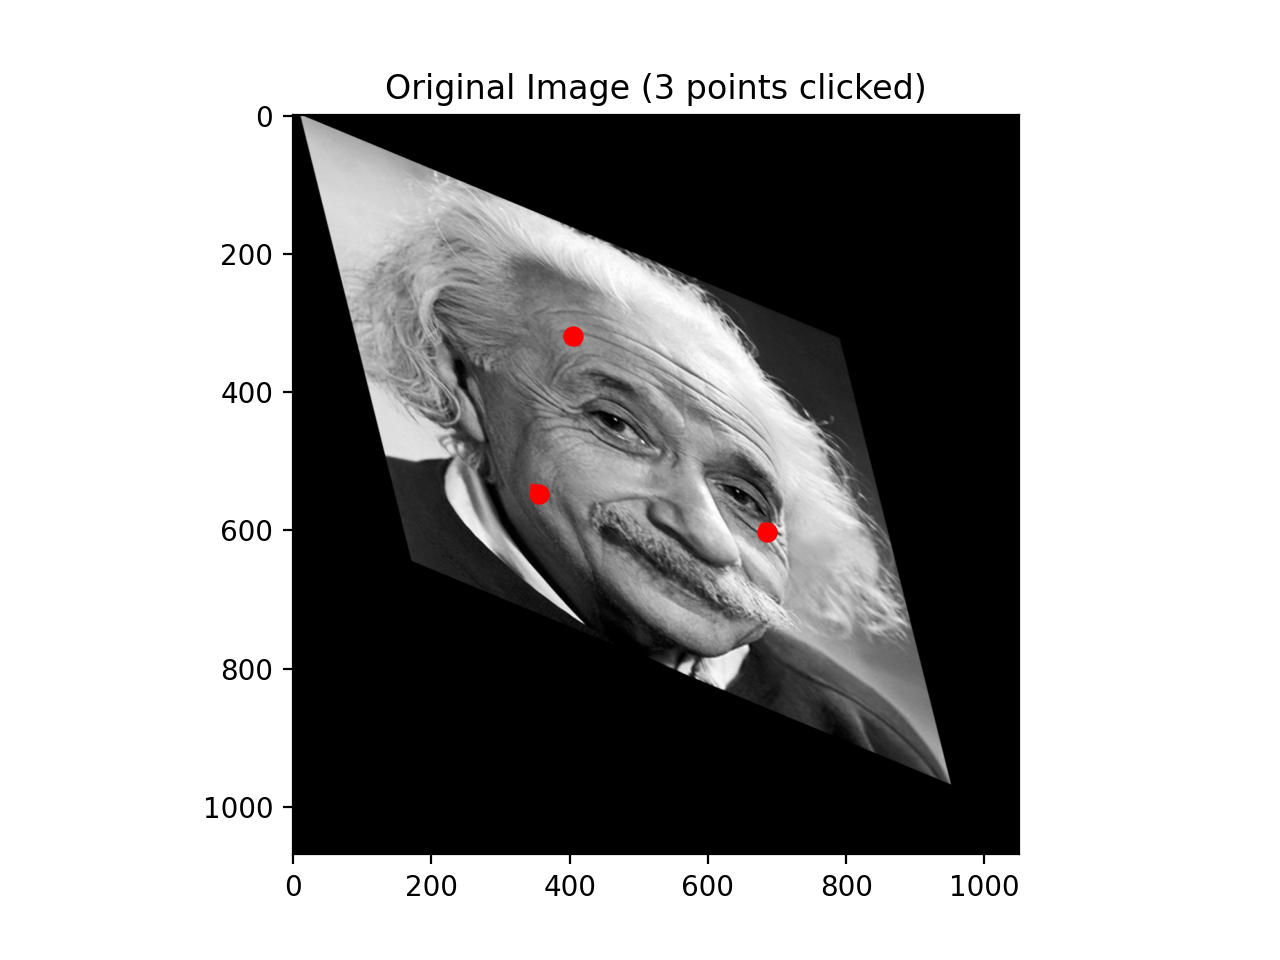

In [17]:
# generate a random 2 x 2 linear matrix
a = 1 + 0.25*(np.random.randn()+3)
b = 0.25*(np.random.randn()+1)
d = 0.25*(np.random.randn()+2)
e = 1 + 0.25*(np.random.randn()+3)
# generate a random 2 x 1 translation vector
c = 20*np.random.rand()
f = 20*np.random.rand()

# pack them into a 2x3 affine matrix
tform1 = np.array([[a, b, c], [d, e, f]])
height, width, _ = im.shape
imT1 = cv2.warpAffine(im,tform1,(np.int32(width*a + height*b + c) + 100,np.int32(width*d + height*e + f) + 100))

# matrix for storing coordinates
pointsAfter = np.zeros((2,0))

# function handling button clicks
def onclick(event):
    global pointsAfter
    pointsAfter = np.hstack((pointsAfter, [[event.xdata], [event.ydata]]))
    plt.title(f"Original Image ({pointsAfter.shape[1]} points clicked)")
    plt.scatter([event.xdata], [event.ydata], c='r', s=40)

# display warped image and prompt user to select 3 points (in same order
# as original)
fig = plt.figure()
plt.imshow(imT1)
cid = fig.canvas.mpl_connect('button_press_event', onclick) # for handling button click
plt.title("Warped image (Click on the 3 points)")
plt.show()

In [18]:
print(pointsBefore)
print(pointsAfter)

[[118.93993506 300.75811688 178.46374459]
 [279.22977543 220.78821699 110.3986066 ]]
[[355.98028274 685.70430871 405.14965503]
 [547.82436671 602.77837104 319.33140135]]


#### Formulate and Solve Equation
We want to solve for the $6$ unknown entries $a,b,c,d,e,f$ of a $2\times 3$ affine transformation matrix $T$ that maps each point (column) in `pointsAfter` back to the corresponding point (column) in `pointsBefore`.

$$
\begin{align}
\begin{pmatrix}
x'\\
y'
\end{pmatrix}
&=
\underbrace{\begin{pmatrix}
a & b & c\\
d & e & f
\end{pmatrix}}_{T}
\begin{pmatrix}
x\\
y\\
1
\end{pmatrix}
\end{align}.
$$




First express on paper a fully constrained linear system $A\bt = \bb$ where the unknown vector $\bt=(a,b,c,d,e,f)$ contains the 6 entries of the affine matrix $T$. Each pair of points provides two constraints, and you have three pairs, resulting in $6$ constraints total. You have $6$ unknowns, so $A$ is a $6\times 6$ matrix. We now can solve the problem

In [19]:
def add_affine_point_constraints(A, i, pointsAfter):
    A[2*i][0] = pointsAfter[0][i]
    A[2*i][1] = pointsAfter[1][i]
    A[2*i][2] = 1
    A[2*i+1][3]= pointsAfter[0][i]
    A[2*i+1][4] = pointsAfter[1][i]
    A[2*i+1][5] = 1
    return A

#
# Compute transformation matrix to convert columns in pointsAfter
# to corresponding colums in pointsBefore
#
# This function should return a 2x3 matrix of the form:
#
# [[a, b, c],
#  [d, e, f]]
#
# where the 2x2 linear matrix is: [[a, b], [d, e]]
# and the 2x1 translation vector is: [[c], [f]]
def compute_transform( pointsBefore, pointsAfter):
    A = np.zeros((6, 6))
    for i in range(3):
        A = add_affine_point_constraints(A,i,pointsAfter)
    pointsBefore = np.reshape(pointsBefore, 6, order='F')  
    t = np.linalg.solve(A,pointsBefore)
    T = np.reshape(t,(2,3))
    return T

Run the following code blocks to check if your function successfully restored the warped image back to its original appearance.

<IPython.core.display.Javascript object>


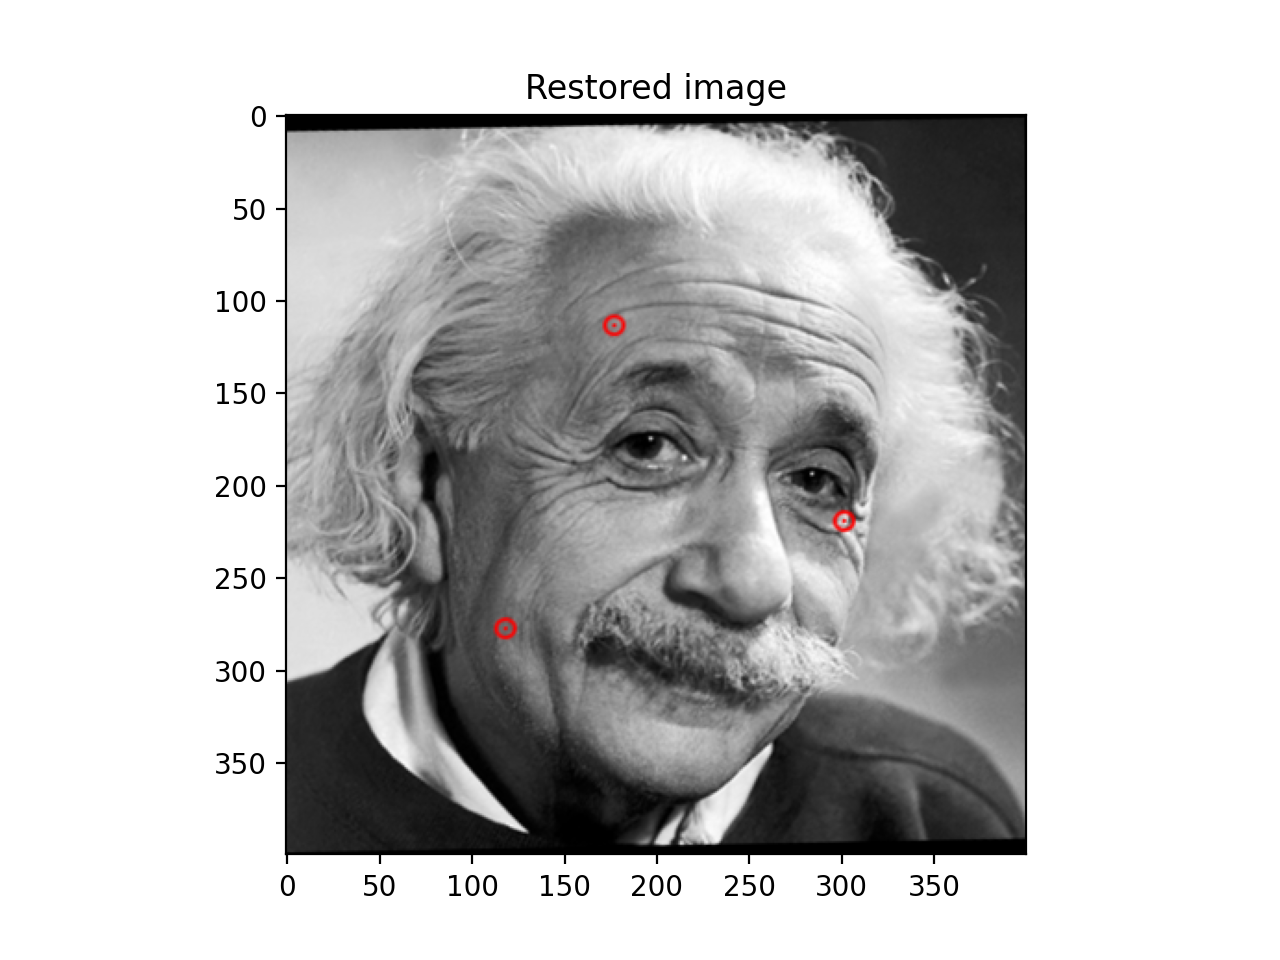

In [20]:
tback = compute_transform( pointsBefore, pointsAfter ) # the matrix to transform warped image back to original

# apply transformation to restore original image
imT2 = cv2.warpAffine( imT1, tback, (height,width))

fig = plt.figure()
plt.imshow(imT2)
plt.title('Restored image')
plt.show()

Additional check. The output should show an approximate identity matrix and an image which applies this matrix to the original.

Approximate Identity Matrix:
[[ 1.0091   0.01044]
 [-0.01905  0.97385]]


<IPython.core.display.Javascript object>


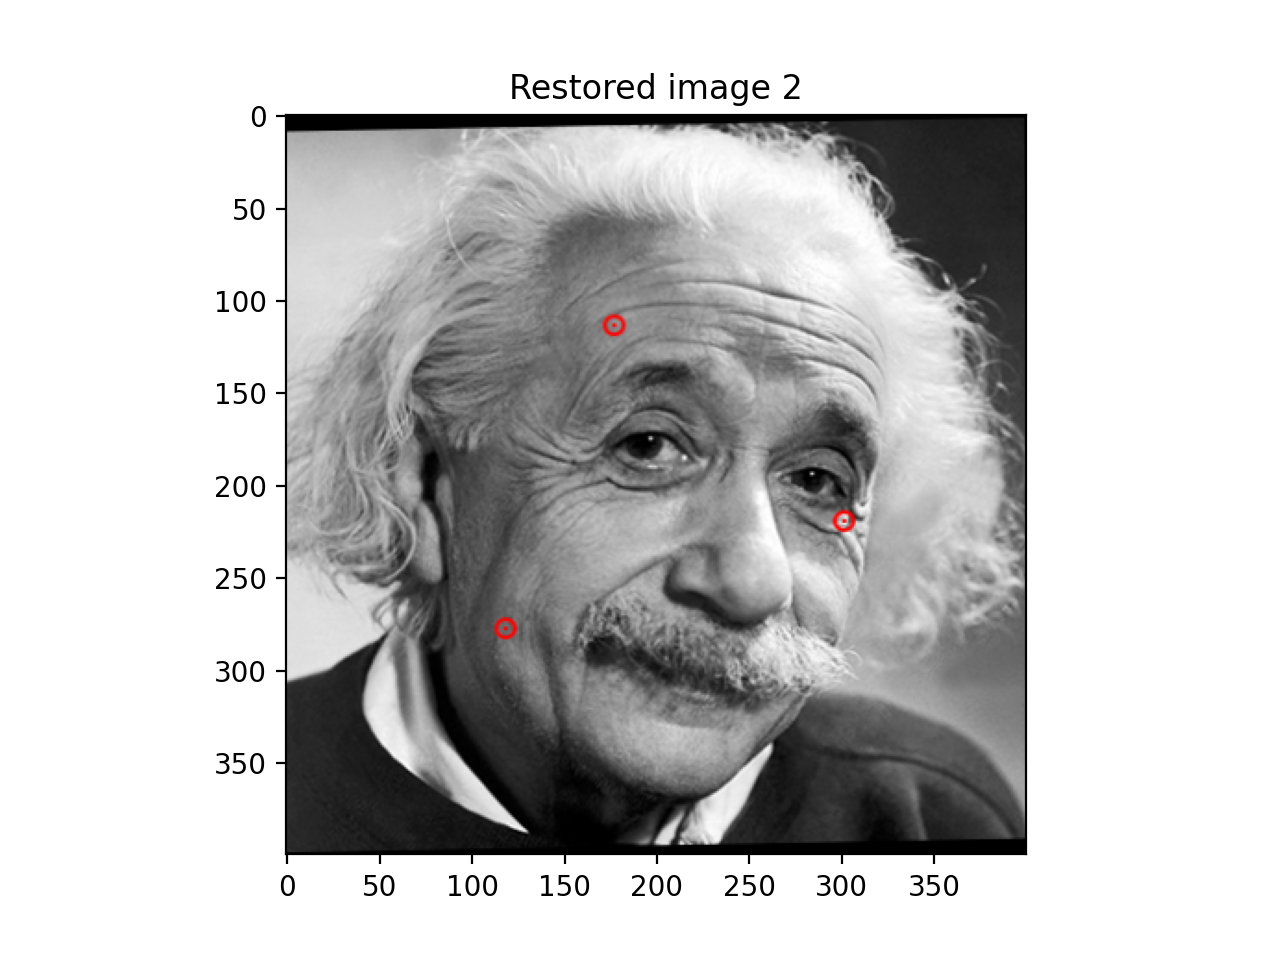

In [21]:
# multiply the forward and backward transforms to get something close to the identity matrix
iT1 = np.vstack([tback, [0,0,1]])
T1 = np.vstack([tform1, [0,0,1]])
ident = iT1 @ T1 
print(f"Approximate Identity Matrix:\n{ident[:2,:2].round(5)}")

imT3 = cv2.warpAffine( im, ident[:2,:], (height,width)) # affine
fig = plt.figure()
plt.imshow(imT3)
plt.title('Restored image 2')
plt.show()

## Perspective Transformations

<IPython.core.display.Javascript object>


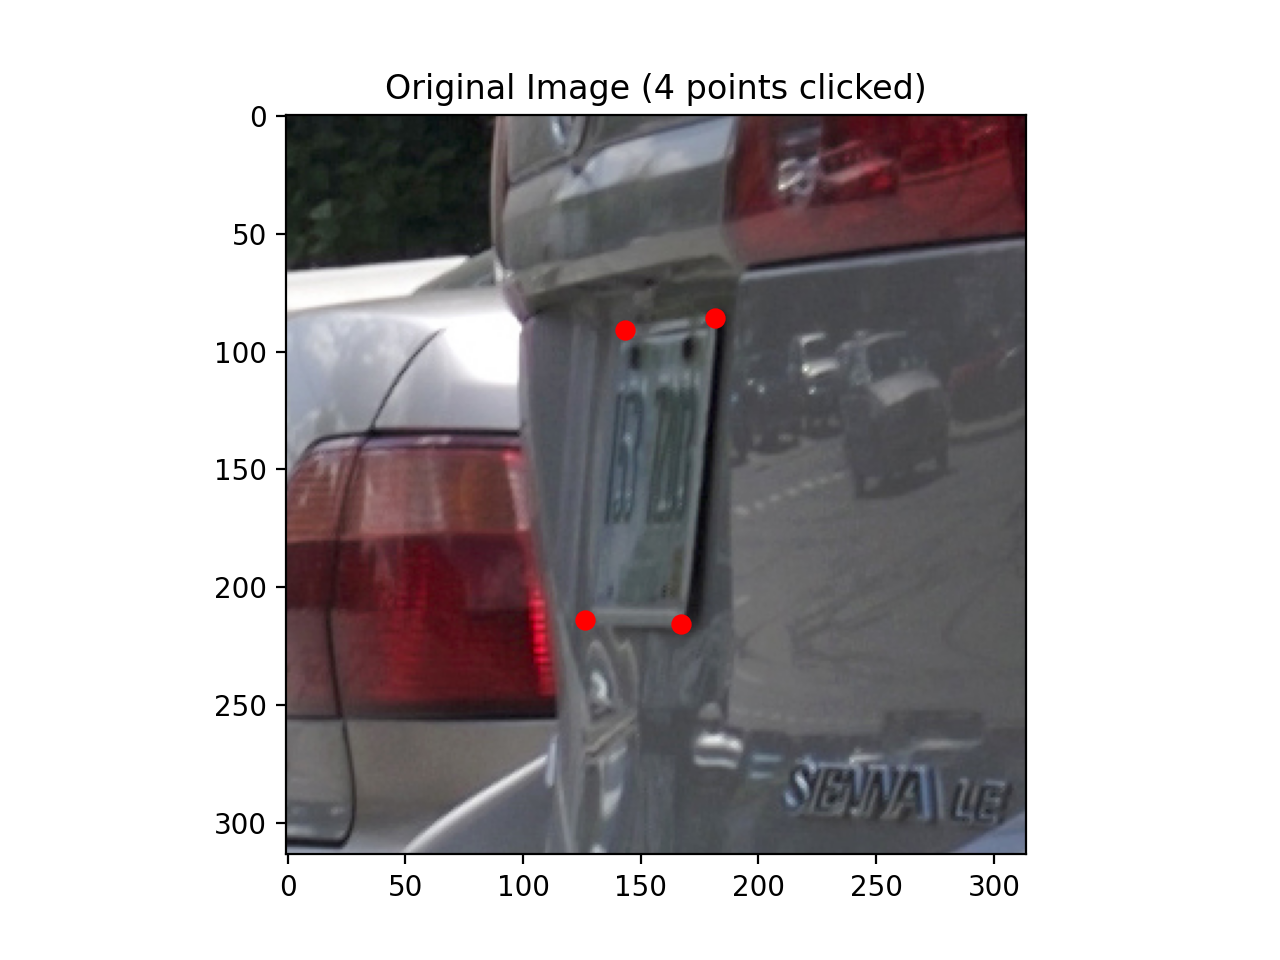

In [25]:
# load image
im = plt.imread( 'images/license.jpg' )

# matrix for storing coordinates
clicked = np.zeros((2,0))

# function handling button clicks
def onclick(event):
    global clicked
    clicked = np.hstack((clicked, [[event.xdata], [event.ydata]]))
    plt.title(f"Original Image ({clicked.shape[1]} points clicked)")
    plt.scatter([event.xdata], [event.ydata], c='r', s=40)

# display original image and prompt user to select 4 points
fig = plt.figure()
plt.imshow(im)
cid = fig.canvas.mpl_connect('button_press_event', onclick) # for handling button click
plt.title("Original Image (Click 4 points)")
plt.show()

We can model the apparant 2D distortion that points undergo due to such perspective projection using a $3 \times 3$ *homography* matrix $H$:
$$
\begin{align*}
\underbrace{\begin{pmatrix}
a & b & c\\
d & e & f\\
g & h & 1
\end{pmatrix}}_{H}
\begin{pmatrix}
x\\
y\\
1
\end{pmatrix} &=
\begin{pmatrix}
w'x'\\
w'y'\\
w'
\end{pmatrix}
\end{align*}.
$$
A homography matrix is always defined up to scale. For simplicity, assume that the bottom right coefficient of the homography is 1.

We want to deduce the entries of the homography $H$ that maps the four corners we clicked above to the four corners of an undistorted rectangular license plate. Our unknowns are the elements of the homography matrix: $a, b, c, d, e, f, g, h$, while, for a given pair of corresponding points, $x, y$ and $x', y'$ are known. $w'$ is not known per say but can be deduced easily from other unknowns and known quantities. Each pair of points gives me two constraints, and with four such pairs, I have 8 constraints on 8 unknowns.

`compute_homography` below takes the four pairs of points and returns a $3 \times 3$ homography matrix $H$ that maps the first point of each pair to the second one. 

In [27]:
# Fill in 2 rows (2*i and 2*i+1) in matrix A to map point p to point q
# Subroutine in compute_homography
def add_homography_point_constraints( A, i, p, q ):
    A[2*i][0] = p[0][i]
    A[2*i][1] = p[1][i]
    A[2*i][2] = 1
    A[2*i][6] = -p[0][i] * q[0][i]
    A[2*i][7] = -p[1][i] * q[0][i]
    A[2*i+1][3] = p[0][i]
    A[2*i+1][4] = p[1][i]
    A[2*i+1][5] = 1
    A[2*i+1][6] = -p[0][i] * q[1][i]
    A[2*i+1][7] = -p[1][i] * q[1][i]
    return A

# estimate homography that maps ps to qs
def compute_homography( ps, qs ):
    A = np.zeros((8,8))
    for i in range(4):
        A = add_homography_point_constraints(A,i,ps,qs)
    qs = np.reshape(qs, 8, order='F')
    h = np.linalg.solve(A, qs)
    h = np.append(h,1)
    H = np.reshape(h,(3,3))
    return H

Test homography properly undistorts the clicked points:

In [28]:
# undistored coordinates of license plates (in pixels), i.e. corners of a rectangle
unwarped = np.array([[ 0, 400, 400,   0 ],
                     [ 0,   0, 200, 200 ]])


H = compute_homography( clicked, unwarped )
print(H)

# multiply H by each of the clicked points, but add a homogeneous coordinate 1 to each of them first
q = H @ np.vstack((clicked, [1, 1, 1, 1]))

# now divide by homogeneous coordinate to project back to 2D
print(np.round(q[:-1, :] / q[-1, :]))

# and compare to original unwarped coordinates
print(unwarped)

[[ 1.61394330e+01  2.22612869e+00 -2.51587549e+03]
 [ 3.44601964e-01  2.58451473e+00 -2.83612689e+02]
 [ 2.20614733e-03  1.32727337e-03  1.00000000e+00]]
[[ -0. 400. 400.   0.]
 [  0.   0. 200. 200.]]
[[  0 400 400   0]
 [  0   0 200 200]]


Now, let's test this function by warping the license plate image by the homography and plotting it:

<IPython.core.display.Javascript object>


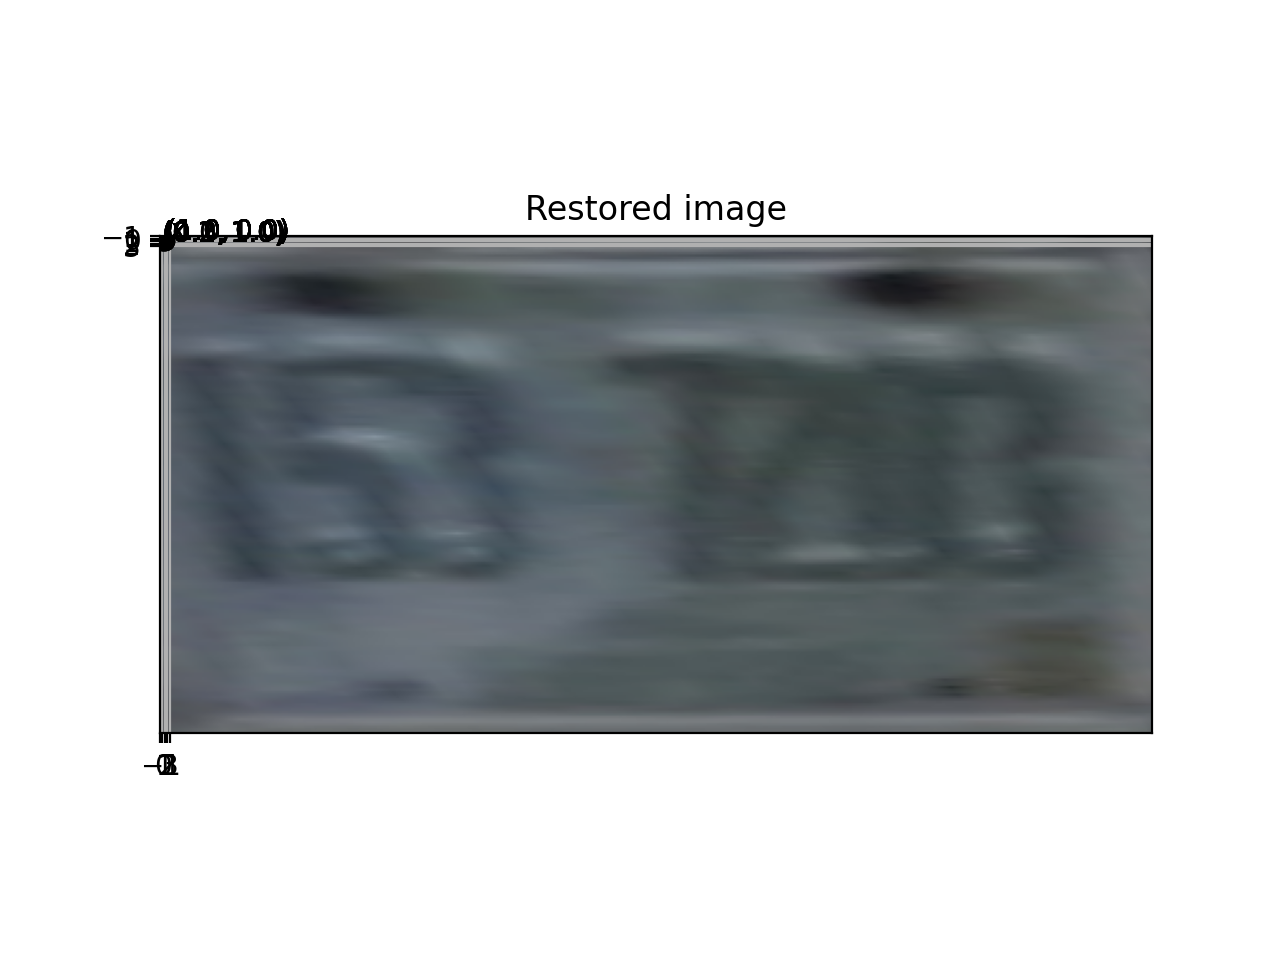

In [29]:
# apply transformation to restore the original
im2 = cv2.warpPerspective( im, H, (400,200))

fig = plt.figure()
plt.imshow(im2)
plt.title('Restored image')
plt.show()